# <h1 style='background:#6daa9f; border:0; color:black'><center>Product Recommendation System for e-commerce businesses</center></h1> 

A well developed recommendation system will help businesses improve their shopper's experience on website and result in better customer acquisition and retention.

The recommendation system, I have designed below is based on the journey of a new customer from the time he/she lands on the business’s website for the first time to when he/she makes repeat purchases.

The recommendation system is designed in 3 parts based on the business context:

* **Recommendation system part I:** Product pupularity based system targetted at new customers

* **Recommendation system part II:** Model-based collaborative filtering approach that learns the latent factors underlying user-item interactions to make recommendations.


When a new customer without any previous purchase history visits the e-commerce website for the first time, he/she is recommended the most popular products sold on the company's website. Once, he/she makes a purchase, the recommendation system updates and recommends other products based on the purchase history and ratings provided by other users on the website. The latter part is done using collaborative filtering techniques.

# **<span style="color:#6daa9f;">1.Recommendation System - Part I</span>**

Popularity based recommendation system: To recommend the most popular items, we can use the PySpark SQL to count the number of occurrences of each product and order the products in descending order based on the count. The top n products can then be recommended to the new customer.

## **<span style="color:#6daa9f;">IMPORTING LIBRARIES</span>**


In [ ]:
# Importing Libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import desc
from pyspark.sql import functions as F

## **<span style="color:#6daa9f;">SPARK SESSION</span>**

In [ ]:
# create a Spark session
spark = SparkSession.builder.appName("PopularityBasedRecommender").enableHiveSupport().getOrCreate()

## **<span style="color:#6daa9f;">EXTRACT DATA</span>**

In [ ]:
# Loading the Dataset
df1 = spark.sql("SELECT * FROM commerce.cleaned_customers")
df2 = spark.sql("SELECT * FROM commerce.cleaned_products")
df3 = spark.sql("SELECT * FROM commerce.cleaned_ratings")

In [ ]:
# Join ratings_df with customers_df and products_df on customerid and productid respectively
df4 = df3.join(df1, df3.customerid == df1.id)
df4 = df4.drop("id")

In [ ]:
df = df4.join(df2, df3.productid == df2.id)
df = df.drop("id")

In [ ]:
df.toPandas()

,customerid,productid,rate,year,month,nickname,Name,unitprice,PriceRange,category,is_valid
0,103737,611,5,2018,1,dung.hoang.5855,le vian opal earrings 1/5 ct tw diamonds 14k s...,839.99,Medium,Jewelry,True
1,103532,45,5,2018,1,lengocchau32,$100 physical gift card,100.00,Low,Others,True
2,103443,207,2,2018,1,huynhthao.trang.1,stackable diamond ring 1/8 ct tw diamonds ster...,179.00,Low,Jewelry,True
3,103879,565,5,2018,1,dq.ninh,diamond hoop earrings 1/10 ct tw round-cut ste...,199.99,Low,Jewelry,True
4,103318,25,5,2018,1,dothanhchung,adidas consortium campus 80s running shoes,27.56,Low,Apparel,True
...,...,...,...,...,...,...,...,...,...,...,...
123740,103510,66,5,2022,3,nguyenlong294,ống hút kim loại,0.00,Low,Others,True
123741,103602,673,5,2022,3,anhchau2206,escape from mogadishu,8.00,Low,Others,True
123742,103602,153,5,2022,3,anhchau2206,bộ thìa đũa dĩa làm từ lúa mạch,5.00,Low,Others,True
123743,22881,256,5,2022,3,hungnq17411,infinity symbol ring 1/6 ct tw diamonds sterli...,299.00,Low,Jewelry,True


## **<span style="color:#6daa9f;">RECOMMENDATION SYSTEM I</span>**

In [ ]:
# Group by product ID and rating and count the number of occurrences
popular_products = df.groupBy(df.productid, df.Name, df.rate).count()

In [ ]:
# Sort the products by count in descending order
most_popular = (popular_products
                .sort(desc('count')))

In [ ]:
# Show the top 10 most popular products
most_popular.toPandas().head(10)

,productid,Name,rate,count
0,1,build your own computer,5,69
1,82,giày sneaker unisex sk8 hi vans - black,5,68
2,96,móc khóa bts phát sáng bts mẫu b,5,67
3,397,hallmark diamonds necklace 1/10 ct tw sterling...,5,66
4,558,open tube twist hoop earrings 10k yellow gold,5,66
5,359,sapphire ring 1/10 ct tw diamonds 10k white gold,5,66
6,92,combo hoa ban,5,65
7,187,cam canh hà nội,5,65
8,619,le vian chocolate diamonds 1/4 ct tw earrings ...,5,65
9,451,triangle necklace 14k yellow gold,5,65


<AxesSubplot:title={'center':'Top 30 Most Popular Products'}, xlabel='Name'>

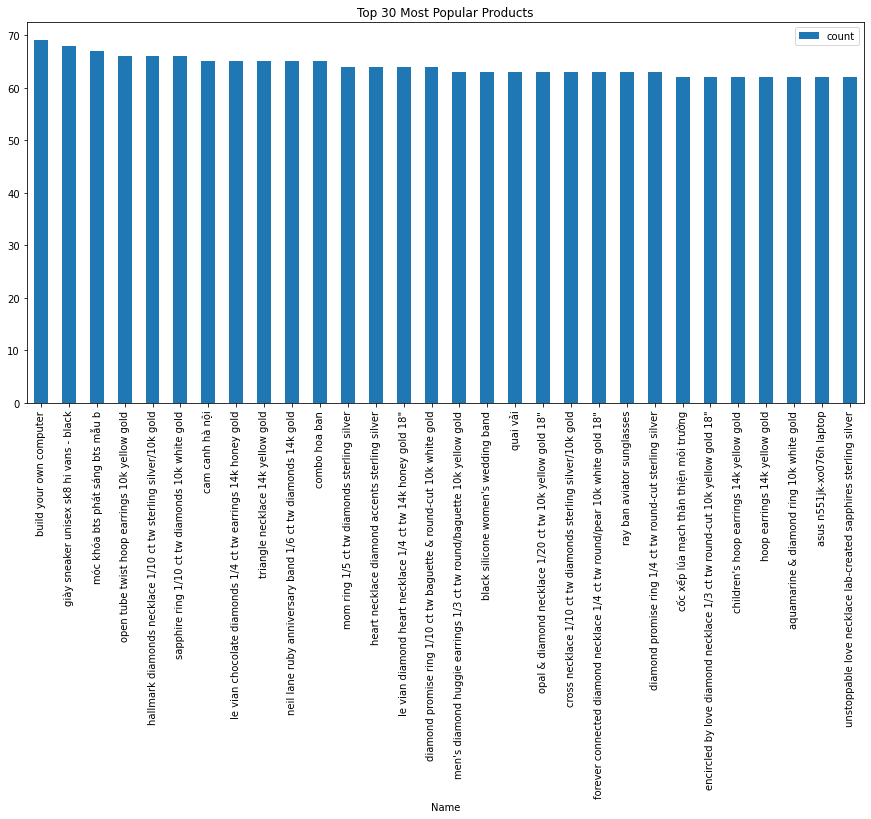

In [ ]:
# Take the top 30 products
top_30_df = most_popular.limit(30)

# Convert the Spark DataFrame to Pandas DataFrame
top_30_pdf = top_30_df.toPandas()

# Plot the bar chart using Pandas plot method
top_30_pdf.plot(x='Name', y='count',kind='bar', figsize=(15,7), title='Top 30 Most Popular Products')

### Analysis:

The above graph gives us the most popular products (arranged in descending order) sold by the business.

For eaxmple, product, build your own computer has sales of over 60.

## **<span style="color:#6daa9f;">STOP SPARK SESSION</span>**

In [ ]:
spark.stop()

# **<span style="color:#6daa9f;">2.Recommendation System - Part II</span>**


Collaborative filtering recommendation system: To build a collaborative filtering system, we can use PySpark's Alternating Least Squares (ALS) algorithm. The dataset needs to be transformed into a matrix with customers as rows and products as columns and the value in each cell representing the rating given by the customer to the product. The ALS algorithm will then generate recommendations for each customer based on the ratings provided by other customers who bought similar products.

## **<span style="color:#6daa9f;">IMPORTING LIBRARIES</span>**

In [ ]:
# Importing Libraries
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import functions as F
from pyspark.sql.functions import *
from pyspark.sql.types import DoubleType
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.recommendation import ALSModel
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import when, col

## **<span style="color:#6daa9f;">SPARK SESSION</span>**

In [ ]:
# create a Spark session
spark = SparkSession.builder.appName("CollaborativeFiltering").enableHiveSupport().getOrCreate()

## **<span style="color:#6daa9f;">EXTRACT DATA</span>**

In [ ]:
# Loading the Dataset
df1 = spark.sql("SELECT * FROM commerce.cleaned_customers")
df2 = spark.sql("SELECT * FROM commerce.cleaned_products")
df3 = spark.sql("SELECT * FROM commerce.cleaned_ratings")

In [ ]:
# Join ratings_df with customers_df and products_df on customerid and productid respectively
df4 = df3.join(df1, df3.customerid == df1.id)
df4 = df4.drop("id")

In [ ]:
df = df4.join(df2, df3.productid == df2.id)
df = df.drop("id")

In [ ]:
df.toPandas()

,_c0,customerid,productid,rate,year,month,_c0,nickname,_c0,Name,unitprice,PriceRange,category,is_valid
0,0,103744,270,4,2018,1,426,edisontoan.nguyen,302,diamond leaf ring 1/10 ct tw round-cut 10k ros...,399.00,Low,Jewelry,True
1,1,103730,673,2,2018,1,445,hienlens,390,escape from mogadishu,8.00,Low,Others,True
2,2,103350,444,1,2018,1,464,huanoppa89,35,deer necklace 1/10 ct tw diamonds sterling sil...,249.00,Low,Jewelry,True
3,3,103653,209,2,2018,1,148,tytoe.tran,178,diamond promise ring 1/5 ct tw round-cut sterl...,289.00,Low,Jewelry,True
4,4,103602,422,1,2018,1,34,anhchau2206,384,color stone mrs. necklace,346.00,Low,Jewelry,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123740,130743,103699,129,5,2022,3,53,kimquyt,441,le bleu homestay dành cho 4 người,30.04,Low,Others,True
123741,130744,103602,341,5,2022,3,34,anhchau2206,429,blue topaz ring 1/6 ct tw diamonds 10k white gold,699.99,Medium,Jewelry,True
123742,130745,103510,222,4,2022,3,45,nguyenlong294,414,black/white diamond promise ring 1/5 ct tw ste...,239.00,Low,Jewelry,True
123743,130746,103758,55,5,2022,3,487,amakaru.xtu,432,tuổi 20 tôi đã sống như một bông hoa dại,2.00,Low,Others,True


In [ ]:
df = df.select('productid', 'customerid', 'rate')
df.toPandas()

,productid,customerid,rate
0,270,103744,4
1,673,103730,2
2,444,103350,1
3,209,103653,2
4,422,103602,1
...,...,...,...
123740,129,103699,5
123741,341,103602,5
123742,222,103510,4
123743,55,103758,5


## **<span style="color:#6daa9f;">Indexing Data Types for ALS Recommendation Model</span>**

In [ ]:
# Converting data type of rating to double type
df = df.withColumn("rate", df["rate"].cast(DoubleType()))

# Indexing customerid column into integer type
user_model = StringIndexer(inputCol="customerid", outputCol="customer_id_index").fit(df)
indexed = user_model.transform(df)
indexed_df = indexed.select(indexed["customer_id_index"].cast(IntegerType()).alias("customerid"), indexed["productid"], indexed["rate"])

# Indexing productid column into integer type
prod_model = StringIndexer(inputCol="productid", outputCol="prod_id_index").fit(indexed_df)
p_indexed = prod_model.transform(indexed_df)
als_df = p_indexed.select(p_indexed["customerid"], p_indexed["prod_id_index"].cast(IntegerType()).alias("productid"), p_indexed["rate"])
als_df.show(5)

+----------+---------+----+
|customerid|productid|rate|
+----------+---------+----+
|        38|      167| 4.0|
|       189|      528| 2.0|
|        60|      257| 1.0|
|        74|      252| 2.0|
|        25|      327| 1.0|
+----------+---------+----+
only showing top 5 rows



## **<span style="color:#6daa9f;">RECOMMENDATION SYSTEM II</span>**


In [ ]:
# Randomly split the data into train and test where 80% data is in train and remaining is test
train, test = als_df.randomSplit([0.8, 0.2])

# Define evaluator as RMSE
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rate", predictionCol="prediction")

# Build the recommendation model using ALS on the training data
# Note we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics
als = ALS(userCol="customerid", itemCol="productid", ratingCol="rate", nonnegative= True, coldStartStrategy='drop')
model = als.fit(train)

# Print the Root Mean Square Error of ALS Model
print("RMSE = ", evaluator.evaluate(model.transform(test)))

# Print default model parameters
print("Rank: ", model.rank)
print("Max Iter: ", model._java_obj.parent().getMaxIter())
print("Reg Param: ", model._java_obj.parent().getRegParam())

RMSE =  1.0865743212325027
Rank:  10
Max Iter:  10
Reg Param:  0.1


In [ ]:
#Tuning model with Parameter Grid Builder
param_grid = ParamGridBuilder() \
     .addGrid(als.rank, [25]) \
     .addGrid(als.regParam, [.1]) \
     .addGrid(als.maxIter, [10]) \
     .build()
# #print(param_grid)

#Build a 10 fold cross validation
crossvalidation = CrossValidator(estimator = als, estimatorParamMaps = param_grid, evaluator = evaluator, numFolds=10)   

#Fit ALS model to training data
best_model = crossvalidation.fit(train).bestModel

#Calculate the RMSE on test data using the best set of parameters obtained after cross validation
print("RMSE value after cross validation is: ", evaluator.evaluate(best_model.transform(test)))
     

RMSE value after cross validation is:  1.0955274864172408


In [ ]:
# View the predictions
test_predictions = best_model.transform(test)

In [ ]:
# Calculate Root Mean Squared Error (RMSE)
rmse = evaluator.evaluate(test_predictions)
print("RMSE:", rmse)

# Calculate Mean Absolute Error (MAE)
mae_evaluator = RegressionEvaluator(metricName="mae", labelCol="rate", predictionCol="prediction")
mae = mae_evaluator.evaluate(test_predictions)
print("MAE:", mae)

# Calculate R-Squared
r2_evaluator = RegressionEvaluator(metricName="r2", labelCol="rate", predictionCol="prediction")
r2 = r2_evaluator.evaluate(test_predictions)
print("R-Squared:", r2)

RMSE: 1.0955274864172408
MAE: 0.8107339794838568
R-Squared: 0.48102690892354394


In [ ]:
# Convert ratings to binary values
threshold = 3.0
test_predictions = test_predictions.withColumn("bin_rating", when(col("rate") >= threshold, 1.0).otherwise(0.0))

# Cast the prediction column to double
test_predictions = test_predictions.withColumn("prediction", col("prediction").cast("double"))

# Create BinaryClassificationEvaluator objects for accuracy
accuracy_evaluator = BinaryClassificationEvaluator(labelCol="bin_rating", rawPredictionCol="prediction", metricName="areaUnderROC")

# Compute accuracy
accuracy = accuracy_evaluator.evaluate(test_predictions)

# Print results
print("Accuracy: ", accuracy)


Accuracy:  0.8665590363778131


In [ ]:
test_predictions.toPandas()

,customerid,productid,rate,prediction,bin_rating
0,0,0,5.0,3.819971,1.0
1,0,1,3.0,3.744592,1.0
2,0,7,2.0,3.903619,0.0
3,0,12,3.0,3.874510,1.0
4,0,13,3.0,3.850754,1.0
...,...,...,...,...,...
24578,343,412,4.0,3.730162,1.0
24579,343,453,4.0,3.768574,1.0
24580,343,485,4.0,3.847624,1.0
24581,343,545,4.0,3.989721,1.0


In [ ]:
# Generate n Recommendations for all users
prod_rec = best_model.recommendForAllUsers(10)
#prod_rec.show()

recommend = prod_rec.toPandas()
recommend.head(5)

# Append customer_id and product_id into a list and create a dataframe
users = []
recommendations = []
#For all data iterations
for i in range(len(recommend)):

    users.append(recommend.iloc[i,0])         #Add customer_id to list
    user_recs = "" 

    for item in recommend.iloc[i,1]:          #Fetching only the product ID's from the recommendations
        user_recs = user_recs + ", " + str(item.asDict()['productid'])
  
    recommendations.append(user_recs[2:])     #Append the productID's to a list

#Create a dataframe with the appended data
recommendations_df = pd.DataFrame(data = zip(users, recommendations), columns=["customer", "Productid"])

#Displaying customers and product recommendations
#(top 10 products) for the first 10 users
recommendations_df.head(10)

/content/spark-3.2.3-bin-hadoop3.2/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


,customer,Productid
0,0,"475, 125, 561, 459, 473, 509, 464, 508, 595, 77"
1,1,"228, 452, 125, 74, 270, 509, 420, 545, 132, 522"
2,2,"509, 563, 521, 536, 179, 473, 524, 579, 142, 74"
3,3,"224, 45, 96, 488, 211, 510, 618, 177, 299, 522"
4,4,"228, 452, 470, 340, 125, 560, 77, 59, 488, 74"
5,5,"561, 224, 74, 509, 406, 125, 508, 228, 452, 66"
6,6,"340, 381, 444, 621, 299, 148, 30, 421, 519, 653"
7,7,"563, 121, 524, 592, 509, 289, 372, 240, 426, 436"
8,8,"459, 545, 561, 23, 156, 261, 450, 475, 492, 218"
9,9,"132, 429, 270, 476, 414, 74, 235, 478, 397, 518"


In [ ]:
# Splitting the top 10 recommendations for each user into separate rows
recommend = prod_rec.selectExpr("customerid", "explode(recommendations)").select("customerid", "col.*")

# Converting the recommendation product IDs from Long to Integer
recommend = recommend.withColumn("productid", recommend["productid"].cast(IntegerType()))



# Join with df2 to get product names
recommend = recommend.join(df2, on=col('productid') == col('id'))

# Convert PySpark dataframe to Pandas
recommend = recommend.toPandas()

# Aggregate the recommended product names for each user
user_recs = recommend.groupby('customerid')['Name'].apply(list).reset_index()

# Displaying users and product recommendations (top 10 products) for the first 10 users
user_recs.head(10)


,customerid,Name
0,0,[diamond cross necklace 1/4 ct tw round-cut 10...
1,1,[diamond promise ring 1/8 ct tw round-cut 10k ...
2,2,[encircled by love diamond necklace 1/3 ct tw ...
3,3,[diamond ring 1/5 ct tw sterling silver/10k ro...
4,4,[diamond promise ring 1/8 ct tw round-cut 10k ...
5,5,[everything you are diamond hoop earrings 3/4 ...
6,6,[lab-created ruby & white lab-created sapphire...
7,7,[diamond hoop earrings 1/2 ct tw round-cut 10k...
8,8,[lab-created emerald necklace 1/6 ct tw diamon...
9,9,"[chân váy b&y, lab-created diamonds by kay cro..."


## **<span style="color:#6daa9f;">TEST</span>**

In [ ]:
# Do the recommendations make sense?

# Splitting the top 10 recommendations for each user into separate rows
recommend2 = prod_rec.selectExpr("customerid", "explode(recommendations)").select("customerid", "col.*")

# Converting the recommendation product IDs from Long to Integer
recommend2 = recommend2.withColumn("productid", recommend2["productid"].cast(IntegerType()))

# Join with df2 to get product names for a specific customer
recommend2 = recommend2.join(df2, on=col('productid') == col('id')).filter('customerid = 6')


# Convert PySpark dataframe to Pandas
recommend2 = recommend2.toPandas()

# Aggregate the recommended product names for each user
user_recs = recommend2.groupby('customerid')['Name'].apply(list).reset_index()

# Displaying users and product recommendations (top 10 products) for the first 10 users
user_recs.head(10)

,customerid,Name
0,6,[lab-created ruby & white lab-created sapphire...


In [ ]:

user_recs = user_recs.explode('Name')
user_recs

,customerid,Name
0,6,lab-created ruby & white lab-created sapphire ...
0,6,lab-created emerald & white lab-created sapphi...
0,6,deer necklace 1/10 ct tw diamonds sterling sil...
0,6,"""laptop dell inspiron 15 n3511 i3 1115g4/4gb/2..."
0,6,diamond ring 1/10 ct tw round-cut 10k white gold
0,6,balo thời trang troy - bigbang
0,6,levi's 511 jeans
0,6,1/6 ct. tw diamond initials couple's heart nec...
0,6,le vian tanzanite ring 3/8 ct tw diamonds 14k ...


In [ ]:
df.filter('customerid = 6').sort('Rate', ascending=False).limit(10).toPandas()

,_c0,customerid,productid,rate,year,month,_c0,id,Name,unitprice,PriceRange,category,is_valid
0,435,6,53,1,2020,10,448,53,[10th] bigbang light stick head,18.00,Low,Others,True
1,754,6,336,1,2018,7,86,336,garnet ring diamond accents 10k yellow gold,299.99,Low,Jewelry,True
2,1215,6,73,1,2021,6,385,73,ống hút kim loại bằng thép không gỉ,2.00,Low,Others,True
3,1773,6,383,1,2020,11,632,383,blue & white lab-created sapphire 'i love you ...,99.99,Low,Jewelry,True
4,1841,6,80,1,2021,3,182,80,giày converse sunflower thấp cổ sf,11.00,Low,Others,True
5,1846,6,257,1,2021,3,186,257,hallmark diamonds lab-created blue sapphire pr...,299.99,Low,Jewelry,True
6,1978,6,104,1,2022,1,242,104,thú bông baby kookie jungkook doll bts bản mini,15.00,Low,Others,True
7,2732,6,685,1,2018,7,269,685,the notebook,1.00,Low,Others,True
8,2898,6,585,1,2019,6,393,585,children's small hoop earrings 14k yellow gold,79.99,Low,Jewelry,True
9,4203,6,197,1,2019,7,236,197,diamond promise ring 1/15 ct tw round-cut ster...,129.00,Low,Jewelry,True


## **<span style="color:#6daa9f;">SAVE MODEL</span>**

In [ ]:
best_model.save("trainedModel/best_modelAls")


[Stage 34:>                                                         (0 + 2) / 2]



## **<span style="color:#6daa9f;">STOP SPARK SESSION</span>**

In [ ]:
spark.stop()